In [8]:
from astropy.table import vstack,Table,Column
import matplotlib.pyplot as plt
import numpy as np
import sncosmo
import os
import snana_read as snread
from imp import reload
import _sncosmo_91bgmodel as sn91bg
reload(sn91bg)
print(sn91bg.SN91bgSource())

class      : SN91bgSource
name       : '91bg model'
version    : color interpolation
phases     : [-18, .., 100] days
wavelengths: [1000, .., 12000] Angstroms
parameters:
  amplitude = 1.0
  stretch   = 1.0
  color     = 0.55


In [9]:
# read raw SNANA data and transfer to SNcosmo format
lc_dir='../snana_sims/snana_results/'
if not os.path.exists(os.path.join(lc_dir, 'sncosmo_fmt')):
    os.mkdir(os.path.join(lc_dir, 'sncosmo_fmt'))
outpath=os.path.join(lc_dir, 'sncosmo_fmt')
snread.write_lc(1000,lc_dir,outpath)

91bg

reduced chi^2: 1.0440435316798609
sim_z: 0.08435
sim_t0: 53674.472656
sim_stretch: 0.803145
sim_color: 0.666517


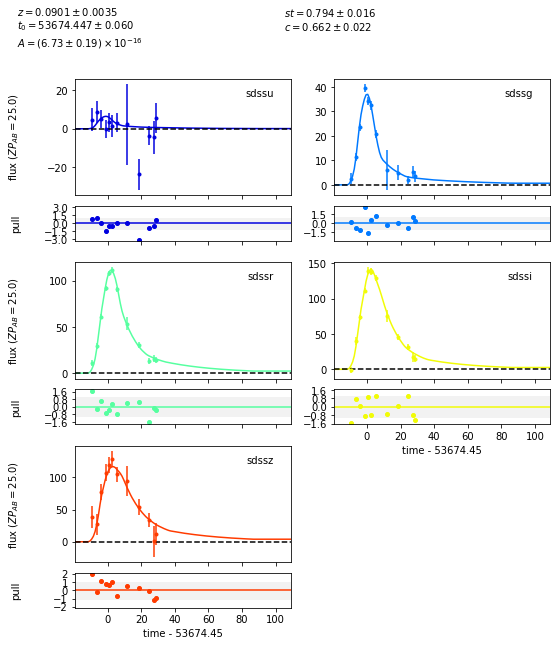

In [14]:
cid = 31
data = Table.read('../snana_sims/snana_results/sncosmo_fmt/sn91bg_{:05d}.csv'.format(cid))
meta = Table.read('../snana_sims/snana_results/sncosmo_fmt/meta.csv')
for par in ['cid','z','t0','st','c']:
    data.meta[par]=meta[par][cid-1]
model=sncosmo.Model(source=sn91bg.SN91bgSource())
model.set(z=0.1)
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['z','t0','amplitude', 'stretch', 'color'],
                                      bounds={'z':(0.01,0.45),'stretch':(0.65,1.25),'color':(0,1)},
                                      guess_z=False)
sncosmo.plot_lc(data,model=fitted_model,errors=result.errors)
print('reduced chi^2:',result.chisq/result.ndof)
print('sim_z:', data.meta['z'])
print('sim_t0:', data.meta['t0'])
print('sim_stretch:', data.meta['st'])
print('sim_color:', data.meta['c'])

Fitting with fixed simulation results

reduced chi^2: 1.0328586566538869
sim_z: 0.08435
sim_t0: 53674.472656
sim_stretch: 0.803145
sim_color: 0.666517


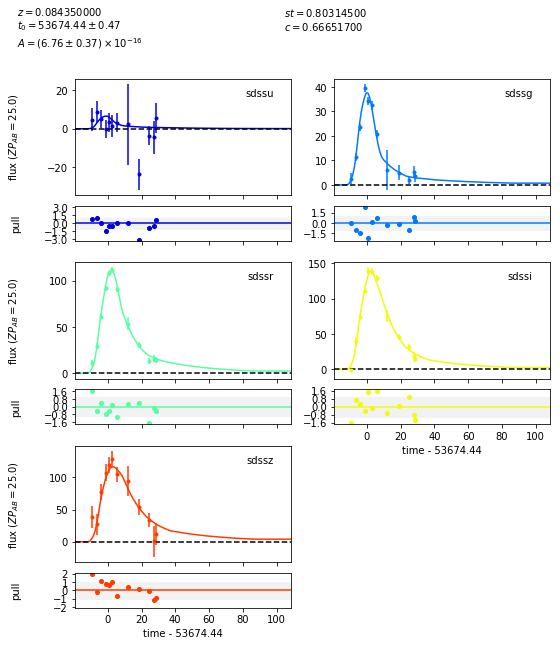

In [15]:
model.set(z=data.meta['z'], stretch=data.meta['st'], color=data.meta['c'])
result, fitted_model = sncosmo.fit_lc(data, model,
                                      ['t0','amplitude'],
                                      bounds=None)
sncosmo.plot_lc(data,model=fitted_model,errors=result.errors)
print('reduced chi^2:',result.chisq/result.ndof)
print('sim_z:', data.meta['z'])
print('sim_t0:', data.meta['t0'])
print('sim_stretch:', data.meta['st'])
print('sim_color:', data.meta['c'])

# Output all fitting results

In [18]:
def fit_all(num,mod,band):
    """
    Run lc-fit for a series of SNe with both salt2 and sn91bg model, output all the fitting results
    
    Args:
        num  (int): how many SN to fit
        mod  (str): which model to use
        band (str): which bands to fit, 'riz' for red, 'ug' for blue and other strings for all
    
    """
    lc=range(num)
    sim_st=[]
    sim_c=[]
    sim_z=[]
    fit_z=[]
    fit_zerr=[]
    fit_st=[]
    fit_sterr=[]
    fit_c=[]
    fit_cerr=[]
    chisq=[]
    redchisq=[]
    cid=[]
    if mod=='91bg':
        model=sncosmo.Model(source=sn91bg.SN91bgSource())
    if mod=='salt2':
        model=sncosmo.Model(source='salt2')
    print(model)
    for i in lc:
        try:
            meta = Table.read('../snana_sims/snana_results/sncosmo_fmt/meta.csv')
            table = Table.read('../snana_sims/snana_results/sncosmo_fmt/sn91bg_{:05d}.csv'.format(i+1))
            #assert(len(table)/5.0>20)
            for par in ['z','t0','st','c']:
                table.meta[par]=meta[par][i]
            if band=='ug':
                mask = (table['band']=='sdssu'+table['band']=='sdssg')
                data = table[mask]
            elif band=='riz':
                mask = (table['band']=='sdssr'+table['band']=='sdssi'+table['band']=='sdssz')
                data = table[mask]
            else:
                data=table
            #model.set(z=0.1) # flat prior for redshift, default is middle point of z bounds
            result, fitted_model = sncosmo.fit_lc(data, model,
                                                  ['z','t0','amplitude','stretch','color'],
                                                  bounds={'z':(0.01,0.45),'stretch': (0.65,1.25), 'color': (0.,1.)})
            sim_st.append(data.meta['st'])
            sim_c.append(data.meta['c'])
            sim_z.append(data.meta['z'])
            fit_st.append(round(result.parameters[3],6))
            fit_sterr.append(round(result.errors['stretch'],6))
            fit_c.append(round(result.parameters[4],6))
            fit_cerr.append(round(result.errors['color'],6))
            fit_z.append(round(result.parameters[0],6))
            fit_zerr.append(round(result.errors['z'],6))
            chisq.append(round(result.chisq,5))
            redchisq.append(round(result.chisq/result.ndof,5))
            cid.append(i+1)
        except:
            continue
    result=Table([cid, sim_z, fit_z, fit_zerr, sim_st, fit_st, fit_sterr, sim_c, fit_c, fit_cerr, chisq, redchisq],
                 names=['cid','sim_z','fit_z','fit_zerr','sim_st','fit_st','fit_sterr',\
                        'sim_c','fit_c','fit_cerr','chi^2','redchi^2'])
    result.write('sn'+mod+'_'+band+'_fit.csv',overwrite=True)


# Output fitting results in red/blue bands

In [19]:
fit_all(10,'91bg','all')
#fit_all(1000,'91bg','ug')
#fit_all(1000,'91bg','riz')

source:
  class      : SN91bgSource
  name       : '91bg model'
  version    : color interpolation
  phases     : [-18, .., 100] days
  wavelengths: [1000, .., 12000] Angstroms
parameters:
  z         = 0.0
  t0        = 0.0
  amplitude = 1.0
  stretch   = 1.0
  color     = 0.55


# Comparison of simulated and fitted parameters

In [517]:
data=Table.read('sn91bg_all_fit.csv')

(0.5, 1.4)

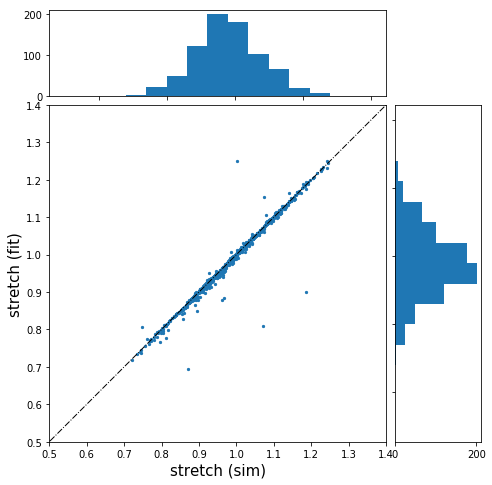

In [519]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_st'],data['fit_st'],s=5)
#ax.errorbar(data['sim_st'],data['fit_st'],yerr=data['fit_sterr'],fmt='.',elinewidth=1)
x_range=(0.5,1.4)
y_range=(0.5,1.4)
ax1.hist(data['sim_st'], bins=15, range=x_range)
ax2.hist(data['fit_st'], bins=15, range=y_range, orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('stretch (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('stretch (fit)',fontsize=15,fontweight='light')
ax.plot(np.arange(0.,2.,0.1),np.arange(0.,2.,0.1),'k-.',linewidth=1)
ax.set_xlim(x_range)
ax.set_ylim(y_range)

(-0.1, 1.1)

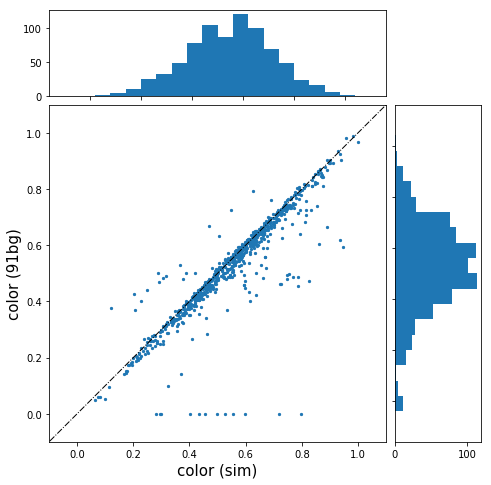

In [520]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_c'],data['fit_c'],s=5)
#ax.errorbar(data['sim_c'],data['fit_c'],yerr=data['fit_cerr'],fmt='.',elinewidth=1)
x_range=(-0.1,1.1)
y_range=(-0.1,1.1)
ax1.hist(data['sim_c'],bins=20, range=x_range)
ax2.hist(data['fit_c'],bins=20, orientation='horizontal',range=y_range)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('color (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('color (fit)',fontsize=15,fontweight='light')
ax.plot(np.arange(-0.5,1.2,0.1),np.arange(-0.5,1.2,0.1),'k-.',linewidth=1)
ax.set_xlim(x_range)
ax.set_ylim(y_range)

(0, 0.35)

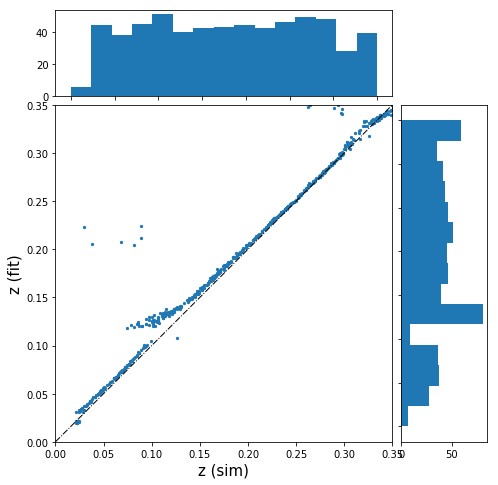

In [521]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_z'],data['fit_z'],s=5)
x_range=(0,0.35)
y_range=(0,0.35)
ax1.hist(data['sim_z'],bins=15,range=x_range)
ax2.hist(data['fit_z'],bins=15,range=y_range,orientation='horizontal')
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('z (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('z (fit)',fontsize=15,fontweight='light')
ax.plot(np.arange(0,1,0.1),np.arange(0,1,0.1),'k-.',linewidth=1)
ax.set_xlim(x_range)
ax.set_ylim(y_range)

Text(0.5,1,'SNANA simulation')

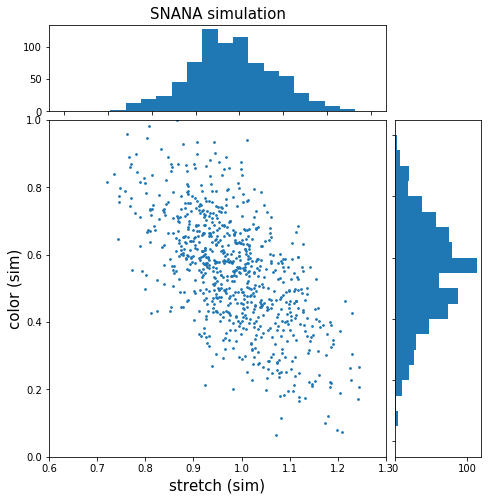

In [522]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['sim_st'],data['sim_c'],s=3)
ax1.hist(data['sim_st'],bins=20,range=(0.6,1.3))
ax2.hist(data['sim_c'],bins=20,orientation='horizontal',range=(0,1))
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('stretch (sim)',fontsize=15,fontweight='light')
ax.set_ylabel('color (sim)',fontsize=15,fontweight='light')
ax.set_xlim(0.6,1.3)
ax.set_ylim(0,1)
ax1.set_title('SNANA simulation',size=15)

Text(0.5,1,'fitted by model_1')

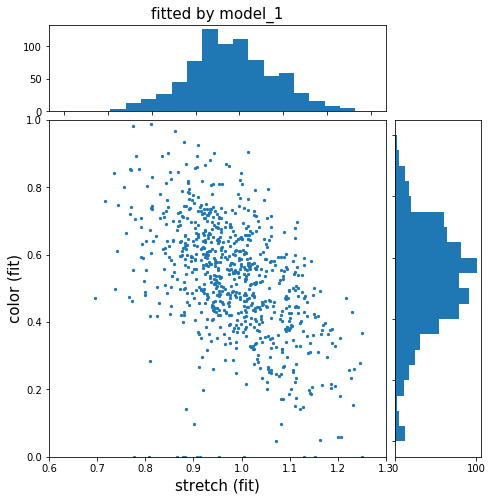

In [523]:
fig=plt.figure(figsize=(6,6))
ax=fig.add_axes((0,0,0.78,0.78))
ax1=fig.add_axes((0,0.8,0.78,0.2))
ax2=fig.add_axes((0.8,0,0.2,0.78))
ax.scatter(data['fit_st'],data['fit_c'],s=5)
x_range=(0.6,1.3)
y_range=(0,1.)
ax1.hist(data['fit_st'],bins=20,range=x_range)
ax2.hist(data['fit_c'],bins=20,orientation='horizontal',range=y_range)
ax1.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_xlabel('stretch (fit)',fontsize=15,fontweight='light')
ax.set_ylabel('color (fit)',fontsize=15,fontweight='light')
ax.set_xlim(x_range)
ax.set_ylim(y_range)
ax1.set_title('fitted by model_1',size=15)